# Data Analytics YTIP2200, part5 - exercises

Return .ipynb file to Optima Return box Sun 21th Mar at latest.
Write in comment field which excercised you've done fully/partly. You can also comment which parts are done/missing.

You can write your solutions in new code cells between existing cells.

Don't use for loops etc.


# 1.   Seconds to Timestamps
File http://gpspekka.kapsi.fi/dataanalytics/part5/gps.txt has gps data with timestamps:

`t401.444483900_1490796_6272051_S36.`

where  
t401 = device id (string)  
444483900 = UTC time, seconds from 1.1.2006 00:00:00 (integer)  
1490796 = longitude * 50000 (integer)  
6272051 = latitude * 100000 (integer)  
S36 = speed (km/h) * 10 (integer)  
  
after device id there is dot and between other fields underscore. In front of speed there is letter S and in the end of the line dot.

Read file to dataframe and convert data to columns:
* device id
* timestamp as Finnish time which has been 2 hours ahead of UTC time (pandas Timestamp)
* longitude (degrees)
* latitude (degrees)
* speed km/h

Head of result:
```
     id                time  longitude  latitude  speed
0  t401 2020-02-01 13:45:00   29.81592  62.72051    3.6
1  t401 2020-02-01 13:45:02   29.81584  62.72052    7.6
2  t401 2020-02-01 13:45:04   29.81580  62.72054    5.4
3  t401 2020-02-01 13:45:06   29.81580  62.72054    0.0
4  t401 2020-02-01 13:45:08   29.81580  62.72054    0.0
```



In [64]:
import pandas as pd
from datetime import datetime

df_gps = pd.read_csv('http://gpspekka.kapsi.fi/dataanalytics/part5/gps.txt',
                     header = None,
                     names = ['raw']
                    )
# Stripping info from raw data
df_gps['device id'] = df_gps['raw'].str.split('.').str.get(0)   
df_gps['time'] = df_gps['raw'].str.split('.').str.get(1).str.split('_').str.get(0)
df_gps['longtitude'] = df_gps['raw'].str.split('.').str.get(1).str.split('_').str.get(1)
df_gps['latitude'] = df_gps['raw'].str.split('.').str.get(1).str.split('_').str.get(2)
df_gps['speed'] = df_gps['raw'].str.split('.').str.get(1).str.split('_').str.get(3).str.strip('S')

# Formatting
df_gps['time'] = pd.to_datetime(df_gps['time'], unit='s')
df_gps['longtitude'] = df_gps['longtitude'].astype(int) / 50000
df_gps['latitude'] = df_gps['latitude'].astype(int) / 100000
df_gps['speed'] = df_gps['speed'].astype(int) / 10

# Drop column with raw data
df_gps.drop(columns = ['raw'], inplace = True)


df_gps.head()
                     
                 
                     
# df_gps['device id'] = df_gps.iloc[:,0].str.split('.')

,device id,time,longtitude,latitude,speed
0,t401,1984-02-01 11:45:00,29.81592,62.72051,3.6
1,t401,1984-02-01 11:45:02,29.81584,62.72052,7.6
2,t401,1984-02-01 11:45:04,29.81580,62.72054,5.4
3,t401,1984-02-01 11:45:06,29.81580,62.72054,0.0
4,t401,1984-02-01 11:45:08,29.81580,62.72054,0.0


# 2. Game weeks
File http://gpspekka.kapsi.fi/dataanalytics/part5/epl5.txt includes all Premier League matches (up to 4th Mar 2021).

Read file and list in which **calendar weeks** (Mon-Sun) have most matches been played. Label weeks according their first day (Monday).   
(Note that around New Year days in same calendar week are usually in different years).

Expected result:
```
1994-12-26    31
1993-12-27    27
2005-12-26    27
1992-08-17    23
1993-08-23    22
1993-08-16    22
```

In [107]:
df_league = pd.read_csv('http://gpspekka.kapsi.fi/dataanalytics/part5/epl5.txt',
                        sep = ';',
                        parse_dates = ['Date']        
                )

# Bubblegum solution to have something to count on later
df_league['Count'] = 1

# Minus one week, as we want sum for the week starting from the given date, not ending on it
df_league['Date'] = df_league['Date'] - pd.to_timedelta(6, unit='d')

# Group by date on weekly freqvence, count games (time entry) with the help of count and sort
df_league = df_league.groupby([pd.Grouper(key='Date', freq='W-Mon')])['Count'] .count() .reset_index() .sort_values('Count', ascending= False)

df_league.head(6)


# Marilla elegantimpi ratkaisu - itselle talteen
# games = df_league.resample('W-Sun', on = 'Date').size().sort_values(ascending=False)
# games.index = games.index - pd.to_timedelta('6d')
# games.head(6)

# Oma innoitukseni
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas

#df_league.info()
# 0 Monday .. 6 Sunday
# df_league['week day'] = df_league['Date'].dt.dayofweek

,Date,Count
124,1994-12-26,31
698,2005-12-26,27
72,1993-12-27,27
1,1992-08-17,23
53,1993-08-16,22
54,1993-08-23,22


# 3. Spurs highs and lows
Read same Premier League file http://gpspekka.kapsi.fi/dataanalytics/part5/epl5.txt and for each day (including non-match days) calculate **how many points Tottenham has achieved from its' previous 38 games** and draw a plot.

As usual win gives 3 points and draw 1 point. According to FTHG and FTAG (full time home goals, full time away goals).

(There are 3 month unchanged line each summer when no games have been played.)

Add vertical lines to (some) dates when club has sacked manager:
* 25 October 2008
* 16 December 2013
* 19 November 2019

Model:
![spurs](http://gpspekka.kapsi.fi/dataanalytics/part5/spurs.png)

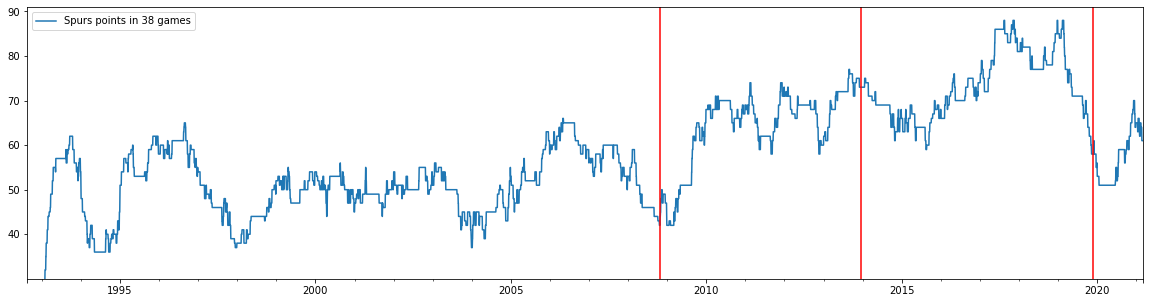

In [230]:
import numpy as np
import matplotlib.pyplot as plt

dfpl = pd.read_csv('http://gpspekka.kapsi.fi/dataanalytics/part5/epl5.txt',
                        sep = ';',
                        parse_dates = ['Date']        
                )

dfpl['H'] = dfpl['HomeTeam']
dfpl['A'] = dfpl['AwayTeam']

cols_to_keep = ['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']

team_results = pd.melt(
    dfpl, 
    id_vars = cols_to_keep, 
    value_vars = ['H', 'A'],
    var_name = 'Home/Away',
    value_name = 'Team')


team_results['Opponent'] = np.where(team_results['Team'] == team_results['HomeTeam'],
                                    team_results['AwayTeam'],
                                    team_results['HomeTeam'])

# win, draw, lost
points_map = {
    'W': 3,
    'D': 1,
    'L': 0
}

def get_result(score, score_opp):
    if score == score_opp:
        return 'D'
    elif score > score_opp:
        return 'W'
    else:
        return 'L'


# Full time goals
team_results['Goals'] = np.where(team_results['Team'] == team_results['HomeTeam'],
                                 team_results['FTHG'],
                                 team_results['FTAG'])
team_results['Goals_Opp'] = np.where(team_results['Team'] != team_results['HomeTeam'],
                                     team_results['FTHG'],
                                     team_results['FTAG'])
team_results['Result'] = np.vectorize(get_result)(team_results['Goals'], team_results['Goals_Opp'])
team_results['points'] = team_results['Result'].map(points_map)

# Drop unnecessary columns and sort by date
cols_to_drop = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Home/Away', 'Opponent', 'Goals', 'Goals_Opp', 'Result']
team_results = (team_results
                    .drop(cols_to_drop, axis=1)
                    .sort_values(by=['Date', 'season']))

# Filter only team Tottenham
team_results = team_results.loc[team_results['Team'] == 'Tottenham']

# Count spurs points
team_results['Spurs points'] = team_results['points'].rolling(min_periods=1, window=38).sum()

# Use dates as index
team_results.set_index('Date', inplace = True)

# Fill in missing dates 
idx = pd.date_range(team_results.index[0], team_results.index[-1]) # create new index with date_range from first game to last
team_results = team_results.reindex(idx, method='ffill') # re-index and fill with previous value



team_results.tail(50)

# Plotting
# Pekka, I decided not to drop the first days even though the example plot suggests you might have done that
# My plot is from first game to last

# setting grid limits and tics
plt.ylim(30,91)
plt.yticks(np.arange(40, 100, step = 10))

# Plotting the chart
chart = team_results['Spurs points'].plot(figsize = (20,5))

# Placing the legend
chart.legend(['Spurs points in 38 games'], loc = 'upper left')

# Manager lines
sacked_manager = pd.to_datetime(['2008-10-25', '2013-12-16', '2019-11-19'])
chart.axvline(x = sacked_manager[0].date(), color = 'red')
chart.axvline(x = sacked_manager[1].date(), color = 'red')
chart.axvline(x = sacked_manager[2].date(), color = 'red')


# https://stackoverflow.com/questions/35456489/legend-not-showing-the-full-text

# 4. Running

File http://gpspekka.kapsi.fi/dataanalytics/part5/running.txt has one runner's daily running kilometers from summers 2015-2019.

For each day between 1st May to 31th October calculate how much more (+) or less (-) 2019's cumulative kilometers are compared to 2018/2017/2016/2015.

Draw plot of these 4 differences. 

Note that not every day has kilometers, but difference should be calculated for each day.

Model:
![running](http://gpspekka.kapsi.fi/dataanalytics/part5/running.png)

,km,season,date,cumsum
2015-05-01,0.0,2015,2015-05-01,0.00
2015-05-02,0.0,2015,2015-05-02,0.00
2015-05-03,0.0,2015,2015-05-03,0.00
2015-05-04,0.0,2015,2015-05-04,0.00
2015-05-05,0.0,2015,2015-05-05,0.00
...,...,...,...,...
2019-10-27,0.0,2019,2019-10-27,728.67
2019-10-28,0.0,2019,2019-10-28,728.67
2019-10-29,0.0,2019,2019-10-29,728.67
2019-10-30,0.0,2019,2019-10-30,728.67


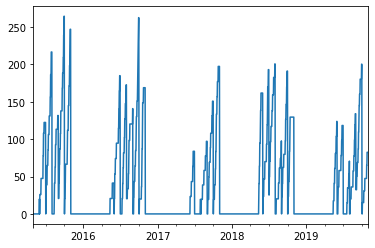

In [528]:
df_run = pd.read_csv('http://gpspekka.kapsi.fi/dataanalytics/part5/running.txt',
                     sep = ',',
                     parse_dates = ['date'],
                     dtype = {'col':np.float}
                )

# Reverse dates, so that oldest is first
#df_run = df_run.iloc[::-1]

df_run.sort_values(by='date', ascending = True, inplace = True)

# Set date as index
df_run.set_index('date', inplace = True)




# Fill in missing dates 
#idx = pd.date_range(df_run.index[0], df_run.index[-1]) # create new index with date_range from first game to last
idx = pd.date_range('2015-05-01', '2019-10-31')
df_run = df_run.reindex(idx, fill_value = 0) # re-index and fill km with 0

# Adding column season that has Year as value
df_run['season'] = df_run.to_period('Y').index

df_run['date'] = df_run.index

# Cumulative sum for every season
df_run['cumsum'] = df_run.groupby('season').cumsum()


# df_2019 = df_run.loc['2019-05-01':'2019-10-31']
# df_2018 = df_run.loc['2018-05-01':'2018-10-31']
# df_2017 = df_run.loc['2017-05-01':'2017-10-31']
# df_2016 = df_run.loc['2016-05-01':'2016-10-31']
# df_2015 = df_run.loc['2015-05-01':'2015-10-31']




df_run.groupby([pd.Grouper(key='date', freq='M'), 'season'])['km'].cumsum().plot()
df_run




# setting grid limits and tics
#plt.ylim(-320,340)
#plt.yticks(np.arange(-300, 310, step = 100))

# Plotting the chart
# chart = df_run.loc['2019-05-01':'2019-10-31'].plot(figsize = (20,7))
# .groupby(['season'])['cumsum']


# Placing the legend
#chart.legend(loc = 'upper left')



# tiputetaan karkauspäivä, jossa ei ollut dataa, koska en halua miettiä miten vaikuttaa
#df_2015_2018 = df_2015_2018.drop(pd.Timestamp('2016-02-29'))
# tällä voi testata tippuiko
# df_2015_2018.loc['2016-02-29']

# https://stackoverflow.com/questions/25669588/convert-percent-string-to-float-in-pandas-read-csv
# https://www.geeksforgeeks.org/python-pandas-series-dt-to_period/

# 5. access.log
File http://gpspekka.kapsi.fi/dataanalytics/part5/accesslog.zip has some data grabbed from one access.log -file:
* client identifier (deriver from ip)
* time
* event id

Calculate **how many unique identifiers there have been in each event in 2 minute time frames**.
(i.e how many different indentifiers have been in each event 11:30:00-11:31:59 etc).

Then plot these figures.

Model:
![event](http://gpspekka.kapsi.fi/dataanalytics/part5/event.png)

Text(0, 0.5, 'identifiers')

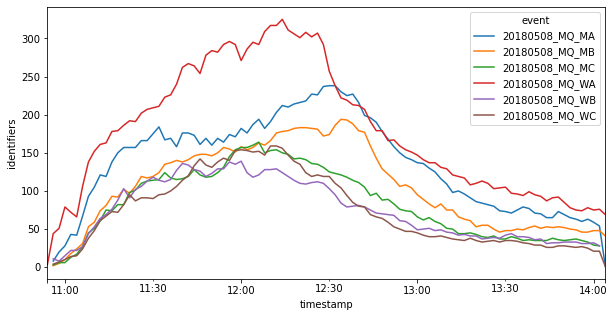

In [477]:
dfac = pd.read_csv('http://gpspekka.kapsi.fi/dataanalytics/part5/accesslog.zip')

# Muunnetaan timestampiksi yhdistämällä kaksi stringiä (näissä kaikissa oli sama pvm, loppuosa vaihteli)
dfac['timestamp'] = pd.to_datetime('2018-05-08 ' + dfac['timestamp'].str[-8:])

# Ryhmitellään eventin ja timestampin mukaan, timestamp myös resamplataan ottaen kahden minuutin välit
# ja lasketaan uniikit ip:t tuona aikavälinä
# unstack, jotta timestamp, event -series saadaan palasiksi, eli timestamp x-akselille ja event legendiin
ax = dfac.groupby([pd.Grouper(key='timestamp', freq='2min'), 'event'])['identifier'].nunique().unstack().plot(figsize = (10,5))
ax.set_ylabel("identifiers")


# itselle talteen välivaiheita 
# Ryhmitellään eventin ja timestampin mukaan, timestamp myös resamplataan ottaen kahden minuutin välit
# ja lasketaan uniikit ip:t tuona aikavälinä
#df_ipt = dfac.groupby(['event', pd.Grouper(key='timestamp', freq='2min')])['identifier'].nunique()
#dfac['timestamp'].iloc[0]
#dfac[10000:10050]
